In [ ]:
#default_exp ocr_attention_training

In [ ]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#export
from ocr.core import save_inference, load_inference
from ocr.ocr_dataset_fontsynth import create_df as create_fontsynth_df
from ocr.ocr_dataset_sroie2019 import create_df as create_sroie_df
from ocr.ocr_dataset_brno import create_df as create_brno_df
from ocr.ocr_dataset_sroie2019 import sroie_ocr_config, char_freq
from ocr.ocr_dataset_fontsynth import fontsynth_config, char_freq
from ocr.ocr_dataset_brno import brno_ocr_config
PAD = sroie_ocr_config.PAD # PAD - how much is data padded
PAD = 0

In [ ]:
#export
allowed_chars = {'N', '3', 'V', 'P', '7', '1', '#', '9', '"', 'C', 'Q', 'B', 'E', '>', '@', ',', 'M', '{', ']', 
                 ';', '^', "'", '&', '6', 'Z', '*', '<', '+', 'G', 'X', '!', ':', '-', '[', '|', '$', '5', 'I', 
                 'H', '=', 'Y', '.', 'R', 'S', '/', 'T', '}', 'K', '0', '?', 'U', ')', '_', 'D', 'J', 'L', '4', 
                 'W', '%', '(', ' ', 'F', '8', '~', '\\', 'A', '2', 'O'}

allowed_chars = fontsynth_config.allowed_chars

allowed_fonts = ['Unknown', 'Andale_Mono', 'Arial', 'Arial_Black', 'Arial_Bold', 'Arial_Bold_Italic', 'Arial_Italic',
'Comic_Sans_MS_Bold', 'Courier_New', 'Courier_New_Bold', 'Courier_New_Bold_Italic', 'Courier_New_Italic',
'Georgia', 'Georgia_Bold', 'Georgia_Bold_Italic', 'Georgia_Italic', 'Impact', 'Times_New_Roman',
'Times_New_Roman_Bold', 'Times_New_Roman_Bold_Italic', 'Times_New_Roman_Italic', 'Trebuchet_MS',
'Trebuchet_MS_Bold', 'Trebuchet_MS_Bold_Italic', 'Trebuchet_MS_Italic', 'Verdana', 'Verdana_Bold',
'Verdana_Bold_Italic', 'Verdana_Italic', 'brno_easy', 'brno_medium', 'sroie2019', 'Comic_Sans_MS']

class attention_config:
    LINE_HEIGHT = 48
    USE_DEFAULT_CLASSES = True
    label_delim = '`'
    pad_idx = 0 # aka: label_delim idx
    allowed_chars = allowed_chars
    allowed_fonts = allowed_fonts

### Prep

In [ ]:
print(char_freq)

{'`': 3, '$': 3, '&': 4, 'Q': 7, ']': 14, '[': 17, '*': 19, '?': 19, '~': 27, '|': 29, 'q': 32, '!': 36, 'Ū': 42, '>': 65, '<': 67, 'Y': 80, '_': 80, 'Z': 82, 'x': 105, '+': 111, 'Į': 118, '=': 124, 'W': 126, '/': 131, "'": 136, 'w': 158, 'Č': 172, 'U': 202, ';': 236, '%': 481, 'Ž': 485, 'F': 503, 'O': 510, 'C': 524, 'H': 563, '-': 816, ':': 921, 'Š': 1024, 'X': 1083, 'G': 1091, 'N': 1190, '7': 1236, '6': 1252, 'E': 1331, '4': 1413, '8': 1423, 'M': 1501, '3': 1583, 'J': 1659, 'B': 1663, 'D': 1670, 'R': 1681, '5': 1704, 'L': 1746, 'h': 1871, 'ę': 2138, 'T': 2366, '2': 2432, 'S': 2494, 'I': 2622, '9': 2684, '"': 2685, 'A': 2872, 'K': 2997, 'V': 3038, '0': 3362, 'P': 3502, ')': 3686, '(': 3703, 'f': 3824, 'z': 4043, '1': 4836, 'ū': 4870, 'č': 5023, 'į': 5912, 'c': 6432, 'ą': 7634, 'ž': 9394, 'š': 12233, 'b': 15668, 'y': 16624, 'ė': 17674, 'ų': 17750, '.': 18061, ',': 18377, 'g': 20651, 'v': 25951, 'j': 27463, 'd': 28630, 'p': 31386, 'l': 39217, 'm': 42216, 'k': 47857, 'u': 52494, 'n': 596

In [ ]:
chars = list(char_freq.keys())
label_delim = attention_config.label_delim
label_delim in chars

True

In [ ]:
allowed_chars = set(chars) - set(['·', label_delim])
print(allowed_chars)
len(allowed_chars)

{'|', 'E', '+', 'G', 'P', 'K', '-', 'g', 'B', 'p', '(', '>', 'u', 'ū', 'A', '0', 'O', 'z', '.', 'Ū', 'M', 'ę', 'ų', 'W', 'C', 'U', '*', 'o', '<', 'Š', '3', '!', 'V', '[', 'į', '4', '7', 'č', '2', 'D', 'Ž', 'w', 'X', '?', 'x', 'T', 'R', 'N', 's', 'd', 'š', 'ė', ':', 'j', 'Į', '_', 'L', 'H', ')', '=', '%', '1', 'F', 'c', 'ą', ' ', '8', 'n', '/', 'a', 'h', 'k', "'", '5', '"', 'Č', 'f', 'm', 'r', 'Z', '9', 'e', 'l', 'y', 'i', '6', 'b', 'Q', '&', ';', 'J', 'q', 'ž', ']', 'I', 'S', ',', 't', 'Y', 'v', '~', '$'}


102

In [ ]:
allowed_chars = attention_config.allowed_chars

In [ ]:
split_chars = lambda string, delim: ''.join([char+delim for char in string])[:-1]

def preprocess_string(string):
    string = string.replace('·', '.')
    string = string.replace('`', "'")
    string = split_chars(string, attention_config.label_delim)
    return string

split_chars('qwerty', label_delim)

'q`w`e`r`t`y'

In [ ]:
sroie_df = create_sroie_df()
print(len(sroie_df))
sroie_df.head()

55915


,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,Y SOON FATT S/B (81497-P),False,sroie2019
1,../data/ocr/sroie2019_lines/X51006327978.1.jpg,"LOT 1504, BATU 8 1/2, JALAN KLANG LAMA,",False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"46000 PETALING JAYA, SELANGOR.",False,sroie2019
3,../data/ocr/sroie2019_lines/X51006327978.3.jpg,TEL : 016-2014209,False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,GST REG NO : 000788250624,False,sroie2019


In [ ]:
brno_df = create_brno_df()
brno_df = brno_df[ brno_df['dataset'].apply(lambda x: 'hard' not in x) ]
brno_df['valid'] = False
print(len(brno_df))
brno_df.head()

438293


,image_path,string,valid,dataset
0,../data/ocr/brno_lines/18256865b4b14a458cd50e1...,on-board the USS CORONADO; a deployable CMOC,False,brno_easy
1,../data/ocr/brno_lines/d2ac2da7d29d2384f6ff36e...,unemployment insurance.,False,brno_easy
2,../data/ocr/brno_lines/55ef7096ba457a8990e05da...,bound was calculated. The upper bound was calc...,False,brno_easy
3,../data/ocr/brno_lines/145c6a2d996117b64538681...,"process elements, so that the requestor agent",False,brno_easy
4,../data/ocr/brno_lines/30b35d49bf5250d675bdb8e...,we have to skolemise both using the same skole...,False,brno_easy


In [ ]:
fontsynth_df = create_fontsynth_df()
fontsynth_df['valid'] = False
print(len(fontsynth_df))
fontsynth_df.head()

50000


,image_path,string,valid,dataset
0,../data/ocr/fontsynth_lines/0.jpg,"ninės dalies skiria Korinto kanalas, ir",False,Courier_New_Bold_Italic
1,../data/ocr/fontsynth_lines/1.jpg,d. 1991 m. rugpjūčio 8 d,False,Comic_Sans_MS
2,../data/ocr/fontsynth_lines/2.jpg,bilietų. Vėliau T. Kukas,False,Impact
3,../data/ocr/fontsynth_lines/3.jpg,"į pietus. Klaipėdos, L",False,Georgia_Bold_Italic
4,../data/ocr/fontsynth_lines/4.jpg,t mokslinio metodo si,False,Arial


In [ ]:
# main_df = pd.concat([sroie_df, fontsynth_df, brno_df])
main_df = sroie_df.copy()

In [ ]:
def filter_elems_with_unknown_chars(string):
    for char in string:
        if char not in attention_config.allowed_chars: return False
    return True
valid_elems = main_df['string'].apply(filter_elems_with_unknown_chars)
print('bfr: {} aftr: {}'.format(len(main_df), len(main_df[ valid_elems ])))
main_df = main_df[ valid_elems ]

bfr: 55915 aftr: 55911


In [ ]:
main_df['string'] = main_df['string'].map(preprocess_string)
main_df

,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),False,sroie2019
1,../data/ocr/sroie2019_lines/X51006327978.1.jpg,"L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`,` `J`...",False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`...",False,sroie2019
3,../data/ocr/sroie2019_lines/X51006327978.3.jpg,T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9,False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,False,sroie2019
...,...,...,...,...
55910,../data/ocr/sroie2019_lines/X51005676548.58.jpg,0`.`6`3,True,sroie2019
55911,../data/ocr/sroie2019_lines/X51005676548.59.jpg,T`O`T`A`L` `:,True,sroie2019
55912,../data/ocr/sroie2019_lines/X51005676548.60.jpg,1`0`.`5`0,True,sroie2019
55913,../data/ocr/sroie2019_lines/X51005676548.61.jpg,0`.`6`3,True,sroie2019


In [ ]:
c = '\n'
assert tensor(list(main_df['string'].apply(lambda x: c not in x))).all()
main_df['string'] = (main_df['string'] + c + main_df['dataset']).map(lambda x: x.split(c))
main_df

,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,[Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-...,False,sroie2019
1,../data/ocr/sroie2019_lines/X51006327978.1.jpg,"[L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`,` `J...",False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"[4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E...",False,sroie2019
3,../data/ocr/sroie2019_lines/X51006327978.3.jpg,"[T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9, sroie2019]",False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,[G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6...,False,sroie2019
...,...,...,...,...
55910,../data/ocr/sroie2019_lines/X51005676548.58.jpg,"[0`.`6`3, sroie2019]",True,sroie2019
55911,../data/ocr/sroie2019_lines/X51005676548.59.jpg,"[T`O`T`A`L` `:, sroie2019]",True,sroie2019
55912,../data/ocr/sroie2019_lines/X51005676548.60.jpg,"[1`0`.`5`0, sroie2019]",True,sroie2019
55913,../data/ocr/sroie2019_lines/X51005676548.61.jpg,"[0`.`6`3, sroie2019]",True,sroie2019


In [ ]:
sparse_df = pd.concat([ main_df[ main_df['valid'] == False ].iloc[0:10000:2], main_df[ main_df['valid'] == True ].iloc[:500] ])
sparse_df.head()

,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,[Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-...,False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"[4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E...",False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,[G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6...,False,sroie2019
6,../data/ocr/sroie2019_lines/X51006327978.6.jpg,"[D`E`S`C, sroie2019]",False,sroie2019
8,../data/ocr/sroie2019_lines/X51006327978.8.jpg,"[P`R`I`C`E, sroie2019]",False,sroie2019


### Databunch

In [ ]:
#export
from ocr.ocr_crnn_training import TextlineProcessor, TextlineAndFont, TextlineList, MyImageList, im2seq_data_collate
from ocr.ocr_crnn_training import one_hot_text, decode_single_ctc, decode_ctc, gaussian_blur, rand_resize

In [ ]:
#export
class TextlineProcessor(TextlineProcessor):
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes, ds.font_classes)
        self.use_default_classes = attention_config.USE_DEFAULT_CLASSES
        self.default_classes = attention_config.allowed_chars
        self.default_font_classes = attention_config.allowed_fonts
            
    def create_classes(self, classes, font_classes):
        self.classes, self.font_classes = classes, font_classes
        if classes is not None:
            self.classes = [attention_config.label_delim] + classes
            self.c2i = {v:k for k,v in enumerate(self.classes)}
            self.f2i = {v:k for k,v in enumerate(font_classes)}

In [ ]:
#export
class TextlineAndFont(ItemBase):
    ''' F = font, S = string
    data: tensor(S), tensor(F)
    obj: str(S), str(F)
    raw: str(S), list(F)
    '''
    def __init__(self, data, obj, raw):self.data, self.obj, self.raw = data, obj, raw
    def __str__(self, n=20):
        string = self.obj[0][:n]+['...'] if len(self.obj[0]) > n else self.obj[0]
        return self.obj[1][:5] +'...'+ attention_config.label_delim.join([str(o) for o in string])
    def __hash__(self): return hash(str(self))

In [ ]:
#export
class TextlineList(ItemList):
    _processor = TextlineProcessor
    def __init__(self, items:Iterator, classes=None, font_classes=None, label_delim:str=None, one_hot:bool=False, **kwargs):
        self.classes = classes
        self.font_classes = font_classes
        items = [(string.split(attention_config.label_delim),font) for string,font in items] # CHANGED
        super().__init__(items, **kwargs)
        self.processor = [TextlineProcessor(self)]

    def get(self, i):
        stridxs, fontidx = self.items[i] # int, list of ints
        return TextlineAndFont( (tensor(stridxs), tensor(fontidx)), 
                                ([self.classes[c] for c in stridxs], self.font_classes[fontidx]), self.items[i])
    
    def analyze_pred(self, nn_output, thresh=0.5, _=None):
        font_pred, y_pred = nn_output # [c1], [s_e,c2]
        assert len(listify(y_pred.shape)) == 2 # (no batch inputs)
        return font_pred.argmax(dim=-1), decode_single_ctc(y_pred.argmax(dim=-1)), _, _ # [1], [seq_len], _, _

    def reconstruct(self, data_out):
        fontidx, t_argmax, _, lengths = data_out # output from data / output from nn_out -> analyze_pred
        stridxs = [int(i) for i in t_argmax]
        fontidx = int(fontidx)
        return TextlineAndFont((one_hot_text(stridxs, self.c), fontidx), 
                                ([self.classes[c] for c in stridxs], self.font_classes[fontidx]), data_out)
    
    @property
    def c(self): return len(self.classes)

In [ ]:
#export
def im2seq_data_collate(batch:ItemsList, pad_idx:int=0)->Tensor:
    if isinstance(batch[0][1], int): return data_collate(batch)
    "Convert `batch` items to tensor data."
    data = to_data(batch) # list of (image, text) pairs
    # image: [3,48,w], text: [n,c], where n's and w's are different
    max_w = max([image.shape[2] for image, (text,font) in data])
    max_h = max([image.shape[1] for image, (text,font) in data])
    max_n = max([text.shape[0] for image, (text,font) in data])
#     _, num_classes = data[0][1].shape
    
    images = torch.zeros(len(batch), 3, max_h, max_w)
    fonts = torch.zeros(len(batch)).long()
#     texts = torch.zeros(len(batch), max_n, num_classes)
    texts = []
    nn_out_seq_len, texts_len = [], []
    for i, (image, (text,font)) in enumerate(data):
        fonts[i] = font
        c,h,w = image.shape
        images[i, : , : , :w ] = image
        images[i, : , : , w: ] = image[:,:,w-1].unsqueeze(2).expand(c,h,max_w-w)
        nn_out_seq_len.append( image_width2seq_len(w) )
        n = text.size(0)
        texts.append( tensor(text) )
#         texts[i, :n , : ] = tensor(text)
#         texts[i, n: , -1 ] = 1
        texts_len.append(n)
#     texts = torch.cat(texts, axis=0)
    return images, (fonts, texts, tensor(nn_out_seq_len).type(torch.int), tensor(texts_len).type(torch.int))

In [ ]:
#export
train_transforms = [
    rand_resize(pad=(0,PAD), p=1.0),
    rotate(degrees=(-2, 2), p=0.6),
    symmetric_warp(magnitude=(-0.03, 0.03), p=0.3),
    rand_zoom(scale=(0.9,1.03), p=0.5),
    brightness(change=(0.35, 0.65), p=0.4),
    contrast(scale=(0.7,1.3), p=0.4),
    gaussian_blur(size=(1, 7), p=0.2),
#     squish(scale=(0.85,1.15), p=0.3),
#     cutout(n_holes=(0,6), length=(1,10)), # black rect
#     tilt(direction=(0,3), magnitude=(-0.2,0.2), p=0.3)
]

valid_transforms = [
    rand_resize(pad=(0,0), p=1.0) # (no padding, but need to resize)
]

In [ ]:
#export
def create_data(df, bs=32):
    ''' DataFrame (df) -> Dataloader (dl) '''
    data = (MyImageList.from_df(df, path='.', cols='image_path')
        .split_from_df(col='valid')
        .label_from_df(cols='string', label_cls=TextlineList, label_delim=attention_config.label_delim)
        .transform((train_transforms, valid_transforms), tfm_y=False)
        .databunch(bs=bs, collate_fn=partial(im2seq_data_collate, pad_idx=attention_config.pad_idx))
        .normalize()
    )
#     data.train_dl.numworkers=0
#     data.valid_dl.numworkers=0

#     def add_beggining_and_end(b):
#         x,y = b
#         y = F.pad(y, (1, 0), value=bos_idx)
#         y = F.pad(y, (0, 1), value=eos_idx)
#         return x,y

#     data.add_tfm(add_beggining_and_end)
    return data

### Model

In [ ]:
#export
def conv_output(w, ss, ps=None, ks=3):
    ''' image width, strides, pools, kernel sizes '''
    for s,p,k in zip(ss,ps,ks):
        s = s[1] if isinstance(s, tuple) else s
        w = w if w%s == 0 else w + 1
        w = (w - k + 2*p)/s + 1 if p is not None else w/s
    return int(w)

In [ ]:
conv_output(129, [2, 1, 2, 1, (2,1), (2,1), 1], [None] * 6 + [0], [3, 3, 3, 3, 3, 3, 3])

31

In [ ]:
#export
_apply_layer = lambda args: args[1](args[0]) # args[0]: x, args[1]: layer => layer(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True, shared_qk=False):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt, self.v_wgt = [nn.Linear(d_model, n_heads*d_head, bias=bias) for o in range(2)]
        self.k_wgt = self.q_wgt if shared_qk else nn.Linear(d_model, n_heads*d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
    
    def forward(self, q, kv, mask=None):
        ''' [b,s_d,512], [b,s_e,512], [1,1,s_d,s_e] -> [b,s_d,512] '''
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(_apply_layer, zip([q,kv,kv], [self.q_wgt,self.k_wgt,self.v_wgt])) # [b,s_d,h*512], [b,s_e,h*512] x 2
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv)) # [b,s_d,h,512], [b,s_e,h,512] x 2
        wq,wv = map(lambda x:x.permute(0, 2, 1, 3), (wq,wv)) # [b,h,s_d,512], [b,h,s_e,512]
        wk = wk.permute(0, 2, 3, 1) # [b,h,512,s_e]
        attn_score = torch.matmul(wq, wk) # [b,h,s_d,s_e]
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None: # NOTE: masks only ones, not zeros!
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score) # [b,h,s_d,s_e]
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1)) # [b,h,s_d,s_e]
        attn_vec = torch.matmul(attn_prob, wv) # [b,h,s_d,512]
        attn_vec = attn_vec.permute(0, 2, 1, 3).contiguous().contiguous() # [b,s_d,h,512]
        attention = attn_vec.view(bs, seq_len, -1) # [b,s_d,h*512]
        return self.ln(q + self.drop_res(self.out(attention)))

In [ ]:
mha = MultiHeadAttention(n_heads=8, d_model=512)
mha(torch.zeros(4,24,512), torch.zeros(4,16,512), torch.zeros(1,1,24,16, dtype=bool)).shape

torch.Size([4, 24, 512])

In [ ]:
#export
def feed_forward(d_model:int, d_ff:int, ff_p:float=0., activ_func=partial(nn.ReLU, inplace=True), double_drop:bool=True):
    ''' [...,d] -> [...,d] '''
    layers = [nn.Linear(d_model, d_ff), activ_func()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

In [ ]:
#export
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    def __init__(self, n_heads, d_model, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None):
        ''' [b,s_e,512], [1,1,s_e,s_e] -> [b,s_e,512] '''
        return self.ff(self.mha(x, x, mask=mask))

In [ ]:
e = EncoderBlock(n_heads=8, d_model=512, d_inner=1024)
e(torch.zeros(4,16,512), torch.zeros(1,1,16,16, dtype=bool)).shape

torch.Size([4, 16, 512])

In [ ]:
#export
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    def __init__(self, n_heads, d_model, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None):
        ''' [b,s_d,512], [b,s_e,512], [1,1,s_d,s_d] -> [b,s_d,512] '''
        return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

In [ ]:
d = DecoderBlock(n_heads=8, d_model=512, d_inner=1024)
d(torch.zeros(4,24,512), torch.zeros(4,16,512), torch.zeros(1,1,24,24, dtype=bool)).shape

torch.Size([4, 24, 512])

In [ ]:
#export
def get_output_mask(inp, pad_idx=1):
    ''' [b,s_e,...] -> [1,1,s_e,s_e] '''
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].type(torch.bool)

In [ ]:
get_output_mask(torch.ones(4,4)).type(torch.int).squeeze()

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]], dtype=torch.int32)

In [ ]:
#export
class PositionalEncoding(Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int): self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [ ]:
#export
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, emb_sz, vocab_sz=None, drop=0.):
        super().__init__()
        self.emb_sz = emb_sz
        if vocab_sz is None: self.embed = None
        else: self.embed = nn.Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(drop)
        self.alpha = nn.Parameter(tensor(1.))
    
    def forward(self, inp):
        ''' [] -> [] '''
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        if self.embed is not None: inp = self.embed(inp)
        return self.drop(inp + self.alpha * self.pos_enc(pos))
#         return self.drop(inp * math.sqrt(self.emb_sz) + self.pos_enc(pos))

In [ ]:
#export
def compose(funcs):
    def func_out(x, *args):
        for f in listify(funcs):
            x = f(x, *args)
        return x
    return func_out

In [ ]:
#export
class TransformerEncoder(Module):
    def __init__(self, n_layers=6, n_heads=8, d_model=512, d_inner=1024, p=0.1, 
                 bias=True, scale=True, double_drop=True):
        self.enc_emb = TransformerEmbedding(d_model, drop=0.) # no need to embed encoding from cnn output
        args = (n_heads, d_model, d_inner, p, bias, scale, double_drop)
        self.encoders = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        
    def forward(self, inp):
        ''' [b,s_e,512], [b,s_d,c] or [b,s_d] -> [b,s_d,c] (c - num classes) ''' 
        enc = self.enc_emb(inp) # 
        return compose(self.encoders)(enc) # [b,s_e,512]

In [ ]:
TransformerEncoder()( torch.zeros(4,12,512) ).shape

torch.Size([4, 12, 512])

In [ ]:
#export
class CNN(nn.Module):
    def __init__(self, d_model, cnn_layers, kernels, strides, channels, padding, nc=3):
        super().__init__()
        layers = []
        for layer,i,o,k,s,p in zip(cnn_layers, [nc] + channels[:-1], channels, kernels, strides, padding):
            layers.append( layer(ni=i, nf=o, ks=k, stride=s, padding=p) )
        self.cnn = nn.Sequential(*layers)
        b,c,h,w = self.cnn(torch.zeros(1,3,48,128)).shape
        self.out = nn.Linear(h*c, d_model)
        print('CNN output = h:{} c:{}'.format(h,c))
        
    def forward(self, x):
        x = self.cnn(x).permute(0,3,1,2)
        b,w,c,h = x.shape
        return self.out(x.view(b,w,-1)) # [b,c,h,w]

In [ ]:
#export
import revtorch as rv

def RevConv(ni, nf, ks, stride, padding):
    assert ni == nf and stride == 1
    f_func = conv_layer(ni//2, nf//2, ks, stride=stride, padding=padding)
    g_func = conv_layer(ni//2, nf//2, ks, stride=stride, padding=padding)
    layers = nn.ModuleList([rv.ReversibleBlock(f_func, g_func)])
    return rv.ReversibleSequence(layers, eagerly_discard_variables = True)

In [ ]:
m = nn.AdaptiveAvgPool2d([2,512]) # this([h,w])([B,H,W]) -> [B,h,w]
input = torch.randn(1, 64, 512)
output = m(input)
print(output.shape)

torch.Size([1, 2, 512])


In [ ]:
#export
def get_normal_cnn(dx=1):
    strides = [2, 1, (2,1), 1, (2,1), 1, (2,1), 1]
    channels = [int(c*dx) for c in [64, 64, 128, 128, 256, 256, 512, 512]]
    cnn_layers = [conv_layer] * len(strides)
    kernels = [3] * len(strides)
    padding = [None] * len(strides) # None - out size doesnt change
    return cnn_layers, channels, kernels, strides, padding

In [ ]:
cnn_layers, channels, kernels, strides, padding = get_normal_cnn()
cnn = CNN(512, cnn_layers, kernels, strides, channels, padding)
cnn(torch.zeros(2,3,48,128)).shape

CNN output = h:3 c:512


torch.Size([2, 64, 512])

In [ ]:
#export
def get_partially_rev_cnn(dx=1):
    strides = [2, 1, (2,1), 1, (2,1), 1, (2,1), 1]
    channels = [int(c*dx) for c in [64, 64, 128, 128, 256, 256, 512, 512]]
    cnn_layers = [conv_layer, RevConv] * (len(strides)//2)
    kernels = [3] * len(strides)
    padding = [None] * len(strides) # None - out size doesnt change
    return cnn_layers, channels, kernels, strides, padding

In [ ]:
cnn_layers, channels, kernels, strides, padding = get_partially_rev_cnn(dx=1/2)
cnn = CNN(512, cnn_layers, kernels, strides, channels, padding)
cnn(torch.zeros(2,3,48,128)).shape

CNN output = h:3 c:256


torch.Size([2, 64, 512])

In [ ]:
#export
class AttentionModel(nn.Module):

    def __init__(self, nclass=10, fclass=10, nc=3, n_layers=6, d_model=512, d_ff=1024, use_rnn=False, bidirectional=False):
        super().__init__()
        
        cnn_layers, self.channels, self.kernels, self.strides, self.padding = get_partially_rev_cnn(dx=1/2)
        self.cnn = CNN(d_model, cnn_layers, self.kernels, self.strides, self.channels, self.padding, nc=nc)
        
        # font prediction
        h,w = 2,d_model
        self.adaptive_pool = nn.AdaptiveAvgPool2d([h,w]) # this([h,w])([B,H,W]) -> [B,h,w]
        f_model = 2 # font embedding
        self.font_ff = nn.Sequential(nn.Linear(h*w, fclass*f_model), nn.ReLU())
        self.font_out = nn.Linear(f_model, 1)
#         self.font_emb = nn.Linear(f_model, d_model)
        
        # text prediction
        self.transformer = TransformerEncoder(n_layers=n_layers, n_heads=8, d_model=d_model, d_inner=d_ff)
        
        self.use_rnn = use_rnn
        if self.use_rnn:
            self.rnn = nn.LSTM(d_model, d_model, bidirectional=bidirectional)
            mult = 1 if not bidirectional else 2
            d_model = d_model * mult
        
        self.out = nn.Linear(d_model, nclass)
        
        self.nclass, self.d_model, self.fclass, self.f_model = nclass, d_model, fclass, f_model

    def forward(self, x):
        ''' [b,c,h,w], [b,s_d] '''
        b,c,h,w = x.shape
        x = self.cnn(x) # [b,w,512]
        f = self.adaptive_pool(x).view(b,-1) # [b,h_a x w_a] (_a = adaptive pool params)
        f_enc = self.font_ff(f).view(-1, self.fclass, self.f_model)
        f_out = self.font_out(f_enc).view(-1, self.fclass)
#         f_emb = self.font_emb(f_enc) # [b,f,512]
        x = self.transformer(x)
        if self.use_rnn: x, _ = self.rnn(x)
        return f_out, self.out(x)

In [ ]:
font_pred, y_pred = AttentionModel()(torch.zeros(2,3,48,128))
y_pred.shape

CNN output = h:3 c:256


torch.Size([2, 64, 10])

In [ ]:
model = AttentionModel()
image_width2seq_len = lambda w: conv_output(w, model.strides, model.padding, model.kernels)
image_width2seq_len(129)

CNN output = h:3 c:256


65

### Data

In [ ]:
data = create_data(sparse_df, bs=8)
data

ImageDataBunch;

Train: LabelList (5000 items)
x: MyImageList
Image (3, 48, 502),Image (3, 48, 566),Image (3, 48, 533),Image (3, 48, 96),Image (3, 48, 117)
y: TextlineList
sroie...Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`...,sroie...4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,`...,sroie...G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`...,sroie...D`E`S`C,sroie...P`R`I`C`E
Path: .;

Valid: LabelList (500 items)
x: MyImageList
Image (3, 48, 272),Image (3, 48, 794),Image (3, 48, 432),Image (3, 48, 504),Image (3, 48, 355)
y: TextlineList
sroie...T`H`O`N`G` `R`E`C`I`P`E,sroie...1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `...,sroie...J`A`L`A`N` `S`S`7`/`2`6`,` `4`7`3`0`1,sroie...P`E`T`A`L`I`N`G` `J`A`Y`A` `S`E`L`A`N`G`...,sroie...T`E`L` `0`3`-`7`8`8`6` `4`8`7`7
Path: .;

Test: None

In [ ]:
# data.show_batch(4, figsize=(10,10))

In [ ]:
dl = iter(data.valid_dl)
i, o = next(dl)
i.shape

torch.Size([8, 3, 48, 794])

In [ ]:
data.c

114

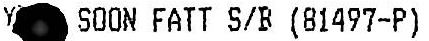

In [ ]:
data.x[0]

In [ ]:
data.y[0]

TextlineAndFont sroie...Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`...

In [ ]:
data.y[0].data

(tensor([59,  1, 53, 49, 49, 48,  1, 40, 35, 54, 54,  1, 53, 17, 36,  1, 10, 26,
         19, 22, 27, 25, 15, 50, 11]), tensor(32))

In [ ]:
del data

### Learner

In [ ]:
#export
from ocr.ocr_crnn_training import CTCFontLoss, AddLossMetrics, WordErrorRate

In [ ]:
data = create_data(main_df, bs=12)
model = AttentionModel(nclass=data.c, fclass=len(data.font_classes))
loss_func = CTCFontLoss(ctc_pad_idx=data.classes.index(attention_config.label_delim))
data

CNN output = h:3 c:256


ImageDataBunch;

Train: LabelList (37471 items)
x: MyImageList
Image (3, 48, 502),Image (3, 48, 756),Image (3, 48, 566),Image (3, 48, 348),Image (3, 48, 533)
y: TextlineList
sroie...Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`...,sroie...L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`...,sroie...4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,`...,sroie...T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9,sroie...G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`...
Path: .;

Valid: LabelList (18440 items)
x: MyImageList
Image (3, 48, 272),Image (3, 48, 794),Image (3, 48, 432),Image (3, 48, 504),Image (3, 48, 355)
y: TextlineList
sroie...T`H`O`N`G` `R`E`C`I`P`E,sroie...1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `...,sroie...J`A`L`A`N` `S`S`7`/`2`6`,` `4`7`3`0`1,sroie...P`E`T`A`L`I`N`G` `J`A`Y`A` `S`E`L`A`N`G`...,sroie...T`E`L` `0`3`-`7`8`8`6` `4`8`7`7
Path: .;

Test: None

In [ ]:
learner = Learner(data, model, loss_func=loss_func, callback_fns=[ShowGraph, AddLossMetrics, WordErrorRate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 8.32E-03


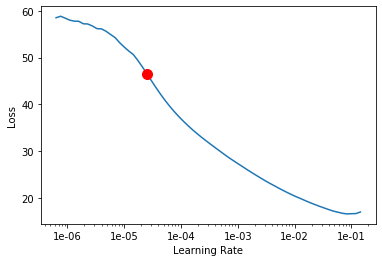

In [ ]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,cer,wer,ctc_loss,font_loss,time
0,0.377023,0.331600,0.092021,0.343850,0.331553,0.000047,09:38


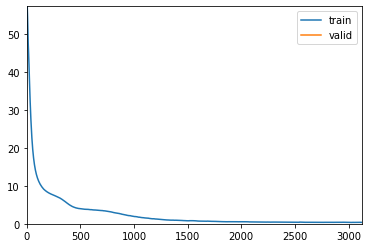

In [ ]:
learner.fit_one_cycle(1, 1e-4)

In [ ]:
save_inference(learner, 'attention_ocr')

In [ ]:
learner.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,cer,wer,ctc_loss,font_loss,time
0,0.293263,0.271230,0.076222,0.302763,0.271226,0.000004,09:41
1,0.210819,0.201306,0.056294,0.222437,0.201306,0.000000,09:42
2,0.169967,0.158459,0.042972,0.194001,0.158459,0.000000,09:42
3,0.144746,0.145810,0.036144,0.167616,0.145810,0.000000,09:42
4,0.089499,0.119620,0.031488,0.131652,0.119620,0.000000,09:43
5,0.079932,0.099696,0.023563,0.113567,0.099697,0.000000,09:44
6,0.059056,0.085380,0.019818,0.094216,0.085380,0.000000,09:42
7,0.037891,0.079941,0.017458,0.084002,0.079941,0.000000,09:43
8,0.027371,0.078241,0.016997,0.080185,0.078241,0.000000,09:42
9,0.025758,0.078147,0.016569,0.078659,0.078147,0.000000,09:42


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,cer,wer,ctc_loss,font_loss,time
0,0.027399,0.079799,0.017403,0.082285,0.079798,0.000000,09:44
1,0.027823,0.086243,0.018971,0.087897,0.086243,0.000000,09:46
2,0.040495,0.089544,0.018788,0.093917,0.089544,0.000000,09:46
3,0.053886,0.100737,0.022940,0.105005,0.100737,0.000000,09:44
4,0.057064,0.110940,0.024891,0.114515,0.110940,0.000000,09:42
5,0.054246,0.098539,0.021681,0.102024,0.098539,0.000000,09:43
6,0.069174,0.088802,0.019932,0.095543,0.088802,0.000000,09:44
7,0.095732,0.127634,0.027493,0.121807,0.127634,0.000000,09:44
8,0.037159,0.104121,0.021388,0.101746,0.104121,0.000000,09:44
9,0.046450,0.089446,0.019886,0.092278,0.089446,0.000000,09:44


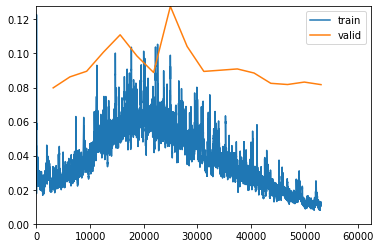

In [ ]:
learner.fit_one_cycle(20, 1e-4)

In [ ]:
save_inference(learner, 'attention_ocr')

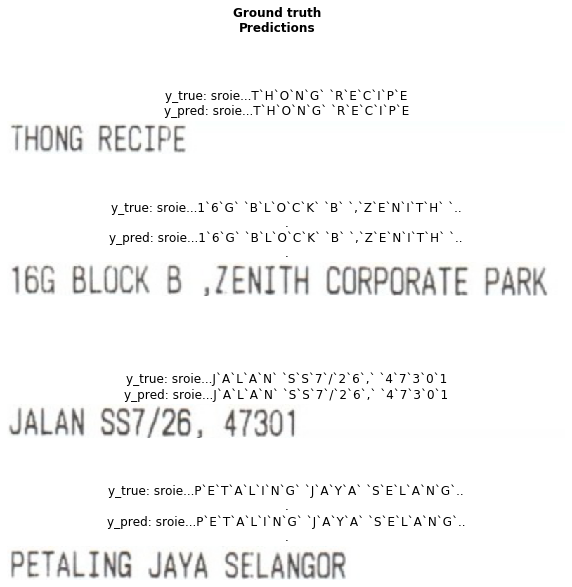

In [ ]:
learner.show_results(DatasetType.Valid, rows=4, figsize=(10,10))

### Examples

In [ ]:
learner = load_inference('attention_ocr')
# learner.data = data

In [ ]:
from pathlib import PosixPath
from ocr.core import *

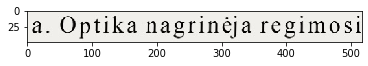

In [ ]:
im = cv2.imread(str(PosixPath('../data/ocr/fontsynth_lines/').ls()[0]))
plot(im)

In [ ]:
pred,_,_ = learner.predict( Image(tensor(im).permute(2,0,1) / 255.) )
chars, font = pred.obj
string = ''.join(chars)
string, font

('A.OPTIKA NAGRINJA REGIMOSI', 'sroie2019')

### Eval

In [ ]:
def calc_precision_recall(true_words, pred_words):
    num_preds, num_trues = len(pred_words), len(true_words)
    
    correct = 0
    for true_word in true_words:
        if true_word in pred_words:
            pred_words.remove(true_word)
            correct += 1
            continue

    precision = correct / num_preds
    recall = correct / num_trues
    # print(precision, recall, correct, num_preds)
    return precision, recall

In [ ]:
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [ ]:
def idx2text(indexes):
    for i in indexes:
        try:
            data.classes[i]
        except:
            print('asd', i)
    return ''.join([data.classes[i] for i in indexes])

In [ ]:
def evaluate_model(model, dl, t2list=lambda t: list(t.cpu().numpy()), total=None):
    total = len(dl) if total is None else total
    errors = 0
    ps, rs, ws, cs = [], [], [], []
    for images, (font, texts, im_lens, text_lens) in tqdm(iter(dl), total=total):
        font_pred, y_pred = model(images)
        y_pred = y_pred.argmax(-1)
        pred_texts = decode_ctc(y_pred)
        for true_words, pred_words in zip(texts, pred_texts): # go through batch
            if list(pred_words.shape) == []:
#                 print('list(pred_words.shape) == []')
                errors += 1
                continue
            true_words, pred_words = t2list(true_words), t2list(pred_words)
            true_str, pred_str = idx2text(true_words), idx2text(pred_words)
            p,r = calc_precision_recall(true_words, pred_words)
            c = wer(true_str, pred_str)
            w = wer(true_str.split(' '), pred_str.split(' '))
            ps.append(p); rs.append(r); ws.append(w); cs.append(c)
    print('errors:', errors)
    return np.array(ps), np.array(rs), np.array(ws), np.array(cs)

# p, r, w, c = evaluate_model(learner.model.train(), data.valid_dl)

In [ ]:
model = learner.model.eval()

In [ ]:
p, r, w, c = evaluate_model(model, learner.data.train_dl)
c.mean(), w.mean(), p.mean(), r.mean()


errors: 2


(0.007755478969301162,
 0.04339869379501086,
 0.9956939948055978,
 0.9947688724869667)

In [ ]:
p, r, w, c = evaluate_model(model, learner.data.valid_dl)
c.mean(), w.mean(), p.mean(), r.mean()


errors: 20


(0.043096733508753336,
 0.18658843018059343,
 0.97496862407098,
 0.9680963568535916)